# mAP ( mean Average Precision )
* 平均平均精度，多个类别AP的平均值，即mAP，是recall和precision组成的曲线下面积
* 检测器的衡量算法
* Evaluation metrics for classification and False positives
    * https://kharshit.github.io/blog/2017/12/29/false-positives
* Evaluation metrics for object detection and segmentation
    * https://kharshit.github.io/blog/2019/09/20/evaluation-metrics-for-object-detection-and-segmentation
* cocoapi
    * https://github.com/cocodataset/cocoapi
* Object-Detection-Metrics
    * https://github.com/rafaelpadilla/Object-Detection-Metrics
* VOC2007数据集镜像：
    * https://pjreddie.com/projects/pascal-voc-dataset-mirror/
* VOC数据集主页：
    * http://host.robots.ox.ac.uk/pascal/VOC/index.html
* COCO数据集主页（Common Objects in Context）：
    * https://cocodataset.org/
* YoloV5 GitHub：
    * https://github.com/ultralytics/yolov5
* 检测类的SOTA模型，也有分类等的SOTA：
    * https://paperswithcode.com/task/object-detection

# 1.定义基本函数，用以加载检测结果和真值结果

In [1]:
import os
import sys
import json
import numpy as np

def iou(a, b):
    ax, ay, ar, ab = a
    bx, by, br, bb = b
    cross_x = max(ax, bx)
    cross_y = max(ay, by)
    cross_r = min(ar, br)
    cross_b = min(ab, bb)
    cross_w = max(0, (cross_r - cross_x) + 1)
    cross_h = max(0, (cross_b - cross_y) + 1)
    cross_area = cross_w * cross_h
    union = (ar - ax + 1) * (ab - ay + 1) + (br - bx + 1) * (bb - by + 1) - cross_area
    return cross_area / union

def nms(bboxes, threshold, confidence_index=-1):
    bboxes.sort(key=lambda x: x[confidence_index], reverse=True)
    flags = [True] * len(bboxes)
    keep = []
    for i in range(len(bboxes)):
        if not flags[i]: continue
        keep.append(bboxes[i])

        for j in range(i+1, len(bboxes)):
            if iou(bboxes[i][:4], bboxes[j][:4]) > threshold:
                flags[j] = False
    return keep

def nms_as_class(bboxes, threshold, class_index=-1, confidence_index=-2):
    boxasclass = {}
    for box in bboxes:
        classes = box[class_index]
        if classes not in boxasclass:
            boxasclass[classes] = []
        boxasclass[classes].append(box)

    output = []
    for key in boxasclass:
        result = nms(boxasclass[key], threshold, confidence_index)
        output.extend(result)
    return output

def xml_value(line):
    p0 = line.find(">") + 1
    p1 = line.find("</", p0)
    return line[p0:p1]

def xml_token(line):
    p0 = line.find("<") + 1
    p1 = line.find(">", p0)
    return line[p0:p1]

def load_voc_xml(file):

    with open(file, "r") as f:
        lines = f.readlines()

    name = None
    box = None
    bboxes = []
    enter_object = False
    enter_part = False
    for line in lines:
        token = xml_token(line)
        
        if token == "object":
            enter_object = True
        elif token == "/object":
            enter_object = False            
        elif enter_object:
            if token == "part":
                enter_part = True
            elif token == "/part":
                enter_part = False

            if not enter_part:
                if token == "name":
                    name = xml_value(line)
                elif token == "bndbox":
                    box = [name]
                    bboxes.append(box)
                elif token in ["xmin", "ymin", "xmax", "ymax"]:
                    box.append(float(xml_value(line)))
    return bboxes

def load_ann(root, call, suffix):
    files = os.listdir(root)
    anns = {}
    for file in files:
        if file.endswith(suffix):
            name = file[:file.rfind(".")]
            anns[name] = call(os.path.join(root, file))
    return anns

def load_json_ann(root):
    def call(file):
        with open(file, "r") as f:
            ann = json.load(f)
        return ann
    return load_ann(root, call, ".json")

def load_xml_ann(root, label_map):
    def call(file):
        return [item[1:] + [0, label_map.index(item[0])] for item in load_voc_xml(file)]
    return load_ann(root, call, ".xml")

In [28]:
# xml -> xmin, ymin, xmax, ymax, class_name[class_index]
# json -> xmin, ymin, xmax, ymax, confidence, class_index

# xml -> {"000001": [[xmin, ymin, xmax, ymax, 0, class_index], [xmin, ymin, xmax, ymax, 0, class_index]]}
# json -> {"000001": [[xmin, ymin, xmax, ymax, confidence, class_index], [xmin, ymin, xmax, ymax, confidence, class_index]]}

# 2.加载标注信息，从xml中加载真值，从json中加载检测后结果

In [2]:
detection_annotation_root = "predict_json"
groundtruth_annotation_root = "groundtruths_xml"
label_map = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
detection_annotations = load_json_ann(detection_annotation_root)
groundtruth_annotations = load_xml_ann(groundtruth_annotation_root, label_map)

for image_id in detection_annotations:
    image_base_annotations = detection_annotations[image_id]
    image_base_annotations = nms_as_class(image_base_annotations, 0.5)
    detection_annotations[image_id] = image_base_annotations

#

* 选择一个image_id

In [3]:
select_image_id = list(detection_annotations.keys())[0]

#

* groundtruth标注信息存储为真值信息，是个dict，格式是：
    - dict{image_id: [[left, top, right, bottom, 0, classes_index], [left, top, right, bottom, 0, classes_index]]}

In [4]:
groundtruth_annotations[select_image_id]

[[157.0, 52.0, 352.0, 443.0, 0, 14]]

#

* detection标注信息存储为检测结果信息，是个dict，格式是：
    - dict{image_id: [[left, top, right, bottom, confidence, classes_index], [left, top, right, bottom, confidence, classes_index]]}

In [5]:
detection_annotations[select_image_id]

[[96.41057252883911,
  29.572640857270173,
  364.5913302898407,
  192.16093577087116,
  0.5754572749137878,
  19.0],
 [90.66634625196457,
  35.78199184952751,
  246.7551827430725,
  182.29164359926457,
  0.04648984596133232,
  19.0],
 [203.31934094429016,
  39.18825566602872,
  361.0266149044037,
  175.5891610393726,
  0.02941707894206047,
  19.0],
 [163.56924176216125,
  53.300862014918074,
  339.52292799949646,
  455.83374401854934,
  0.8888785243034363,
  14.0],
 [18.022313714027405,
  22.86302064131594,
  341.5387272834778,
  458.39725032965134,
  0.010711569339036942,
  6.0]]

# 3.选择一个类别，比如这里是类别0，暂时先计算他的Average Percision

In [6]:
compute_classes_index = 0

* IoU的计算，此时是实现可以允许a是jx1，b是1xk。结果是jxk

In [7]:
def iou(a, b):
    aleft, atop, aright, abottom = [a[i] for i in range(4)]
    awidth = aright - aleft + 1
    aheight = abottom - atop + 1

    bleft, btop, bright, bbottom = [b[i] for i in range(4)]
    bwidth = bright - bleft + 1
    bheight = bbottom - btop + 1

    cleft = np.maximum(aleft, bleft)
    ctop = np.maximum(atop, btop)
    cright = np.minimum(aright, bright)
    cbottom = np.minimum(abottom, bbottom)
    cross_area = (cright - cleft + 1).clip(0) * (cbottom - ctop + 1).clip(0)
    union_area = awidth * aheight + bwidth * bheight - cross_area
    return cross_area / union_area

# 4.构建matched_table
- 针对每一个图像，选择该图像上指定的类别（compute_classes_index）的groundtruth和detection框
- 构建matched_table，格式如下：
    - 每一行的格式是：[confidence, matched_iou, matched_groundtruth_index, image_id]
    - 行数是所有图像的指定类别（compute_classes_index）的detection数量总和
    - matched_groundtruth_index是当前detection的框，与其图像上所有同类别groundtruth框IoU最大的那个的索引
    - matched_iou则是与当前detection最匹配的matched_groundtruth_index的IoU
- 对matched_table进行排序，基于confidence倒序（大的在前面，小的在后面）
- 同时统计该类别的groundtruth的总数量备用

In [8]:
matched_table = []
sum_groundtruth = 0
max_dets = 100

for image_id in groundtruth_annotations:
    select_detection = np.array(list(filter(lambda x:x[5] == compute_classes_index,\
                                            detection_annotations[image_id])))
    select_groundtruth = np.array(list(filter(lambda x:x[5] == compute_classes_index,\
                                              groundtruth_annotations[image_id])))

    num_detection = len(select_detection)
    num_groundtruth = len(select_groundtruth)

    num_use_detection = min(num_detection, max_dets)
    sum_groundtruth += num_groundtruth

    if num_detection == 0:
        continue

    if len(select_groundtruth) == 0:
        for index_of_detection in range(num_use_detection):
            confidence = select_detection[index_of_detection, 4]
            matched_table.append([confidence, 0, 0, image_id])
        continue

    sgt = select_groundtruth.T.reshape(6, -1, 1)
    sdt = select_detection.T.reshape(6, 1, -1)

    # num_groundtruth x num_detection
    groundtruth_detection_iou = iou(sgt, sdt)
    for index_of_detection in range(num_use_detection):
        confidence = select_detection[index_of_detection, 4]
        matched_groundtruth_index = groundtruth_detection_iou[:, index_of_detection].argmax()
        matched_iou = groundtruth_detection_iou[matched_groundtruth_index, index_of_detection]
        matched_table.append([confidence, matched_iou, matched_groundtruth_index, image_id])

matched_table = sorted(matched_table, key=lambda x: x[0], reverse=True)

In [9]:
matched_table[:10]

[[0.9423317909240723, 0.712588290494865, 0, '009329'],
 [0.9255480170249939, 0.8816558261119185, 0, '007403'],
 [0.9168242812156677, 0.9117074880579924, 0, '001126'],
 [0.9092625975608826, 0.9145634697725846, 0, '002908'],
 [0.9072845578193665, 0.8018974517723729, 0, '004680'],
 [0.9016928672790527, 0.7523156813153937, 0, '002014'],
 [0.9016156196594238, 0.8589403037786615, 0, '008881'],
 [0.8957498669624329, 0.7255727715464821, 0, '009167'],
 [0.8921591639518738, 0.8721837634620767, 0, '008950'],
 [0.8904922604560852, 0.7163512422678984, 0, '009211']]

# 5.计算AP@0.5的precision、recall曲线
* 0.5指IoU的阈值是0.5，如果需要计算AP@0.75，直接指定阈值0.75即可
* 当某一个detection的最优匹配的IoU > threshold时，被认为检测成功，
    * 对应的groundtruth如果第一次出现，则该detection被认为是true_positive，否则是false_positive
* 当选中一个true_positive时，其对应的groundtruth设置为见过（seen)，以后任何detection见到他都不能够匹配为true_positive
* Recall的计算公式为：
    $$ Recall=\frac{TP}{TP + FN} = \frac{TP}{\#ground truths} $$
* Precision的计算公式为：
    $$ Precision=\frac{TP}{TP + FP} = \frac{TP}{\#detections} $$
* 对于检测任务而言，真实值只有Positive，没有Negative。预测值只有Positive，没有Negative
    - 也因此，咱们只有FN、FP、TP没有TN
    - 所以，TP + FN，就是ground truths的数量
    - 所以，TP + FP，就是detections的数量
* 其中TP/FP/TN/FN如下：

|-|预测=Negative|预测=Positive|
|--|--|--|
|真实=Negative|(True Negative)TN|(Fase Positive)FP|
|真实=Positive|(False Negative)FN|(True Positive)TP|

![image.png](计算精度1.png)
![image.png](计算精度2.png)

* np.cumsum，返回累积和，例如 [1, 2, 0, 1]，返回 [1, 3, 3, 4]

In [10]:
np.cumsum([1, 2, 0, 1])

array([1, 3, 3, 4])

In [11]:
iou_threshold = 0.5
num_dets = len(matched_table)
true_positive = np.zeros((num_dets, ))

groundtruth_seen_map = {item[3] : set() for item in matched_table}
for index, (confidence, matched_iou, matched_groundtruth_index, image_id) in enumerate(matched_table):
    image_base_seen_map = groundtruth_seen_map[image_id]
    if matched_iou >= iou_threshold:
        if matched_groundtruth_index not in image_base_seen_map:
            true_positive[index] = 1
            image_base_seen_map.add(matched_groundtruth_index)

num_predicts = np.arange(1, len(true_positive) + 1)
accumulate_true_positive = np.cumsum(true_positive)
precision = accumulate_true_positive / num_predicts
recall = accumulate_true_positive / sum_groundtruth

In [12]:
import matplotlib.pyplot as plt

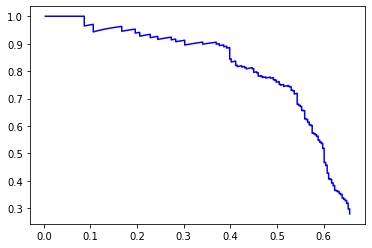

In [13]:
plt.plot(recall, precision, "b-")

# 6.平滑precision曲线

<img src="interpolated_precision_v2.png">

In [14]:
x = [1, 1, 0, 2, 0, 0]
np.maximum.accumulate(x)

array([1, 1, 1, 2, 2, 2])

In [15]:
x = [1, 2, 3]
np.flip(x)

array([3, 2, 1])

In [16]:
mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
mpre = np.concatenate(([0.], precision, [0.]))

# Compute the precision envelope
mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

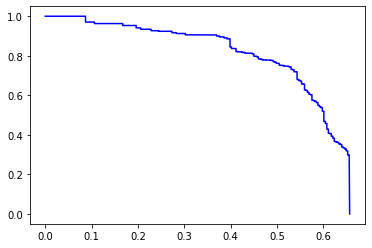

In [17]:
plt.plot(mrec, mpre, "b-")

# 7.计算precision、recall曲线下面积得到Average Precision
* 第一种是11点法，来自VOC2007的评估方法
* 第二种是连续的所有点积分，来自VOC2012的评估方法
* 第三种是101点法，来自COCO所采用，也是目前COCO数据集的评估方法和大部分竞赛评估方法

### np.interp(x, xp, fp, left=None, right=None, period=None)
* 一维线性插值函数，计算指定xp、fp时取x时的插值结果
* x，对于满足fp = f(xp)的函数f而言，需要获取多少个值，以计算output = f(x)
* xp，用于得到函数f，满足fp = f(xp)
* fp，用于得到函数f，满足fp = f(xp)
* left，指定左边界
* right，指定右边界

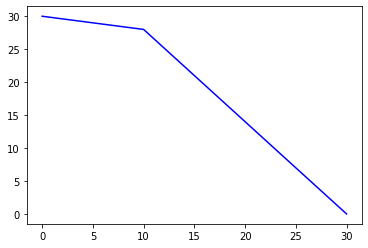

In [18]:
xp = 0, 10, 30
fp = 30, 28, 0
plt.plot(xp, fp, "b-")

In [32]:
x = 5, 20
np.interp(x, xp, fp)

array([29., 14.])

In [35]:
#np.linspace(0, 1, 5)

In [31]:
xs = np.linspace(xp[0], xp[-1], 20)
inter_point = np.interp(xs, xp, fp)

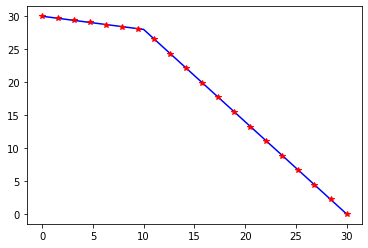

In [21]:
plt.plot(xp, fp, "b-")
plt.plot(xs, inter_point, "r*")

* 计算101点插值的ap ( COCO )

In [22]:
x = np.linspace(0, 1, 101)
average_precision = np.mean(np.interp(x, mrec, mpre))
class_name = label_map[compute_classes_index]
print(f"COCO 101point ap: Class {compute_classes_index:02d}[{class_name:11s}] AP@{iou_threshold} = {average_precision:.3f}")

COCO 101point ap: Class 00[aeroplane  ] AP@0.5 = 0.545


* 计算11点插值的ap ( VOC2007 )

In [23]:
x = np.linspace(0, 1, 11)
average_precision = np.mean(np.interp(x, mrec, mpre))
class_name = label_map[compute_classes_index]
print(f"VOC2007 11point ap: Class {compute_classes_index:02d}[{class_name:11s}] AP@{iou_threshold} = {average_precision:.3f}")

VOC2007 11point ap: Class 00[aeroplane  ] AP@0.5 = 0.541


* 计算连续点（全部修改过的点，因为recall会有重复，所以计算面积时候去掉重复后算）的ap( VOC2012 )

In [24]:
recall_has_changes_condiation = mrec[1:] != mrec[:-1]
recall_has_changes_index = np.where(recall_has_changes_condiation)[0]  # points where x axis (recall) changes (VOC2012)
average_precision = np.sum((mrec[recall_has_changes_index + 1] - mrec[recall_has_changes_index]) * mpre[recall_has_changes_index + 1])  # area under curve
print(f"VOC2012 11point ap: Class {compute_classes_index:02d}[{class_name:11s}] AP@{iou_threshold} = {average_precision:.3f}")

VOC2012 11point ap: Class 00[aeroplane  ] AP@0.5 = 0.546


# 8.汇总所有代码计算mAP，即所有类别ap的平均值

In [25]:
def compute_area_under_curve(precision, recall, method="interp101"):
    
    mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
    mpre = np.concatenate(([0.], precision, [0.]))
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))
    
    if method == "interp101":
        x = np.linspace(0, 1, 101)
        average_precision = np.mean(np.interp(x, mrec, mpre))
    elif method == "interp11":
        x = np.linspace(0, 1, 11)
        average_precision = np.mean(np.interp(x, mrec, mpre))
    else:
        recall_has_changes_condiation = mrec[1:] != mrec[:-1]
        recall_has_changes_index = np.where(recall_has_changes_condiation)[0]  # points where x axis (recall) changes (VOC2012)
        average_precision = np.sum((mrec[recall_has_changes_index + 1] - mrec[recall_has_changes_index]) * mpre[recall_has_changes_index + 1])  # area under curve
    return average_precision

def compute_ap(matched_table, iou_threshold, sum_groundtruth):
    num_dets = len(matched_table)
    true_positive = np.zeros((num_dets, ))

    groundtruth_seen_map = {item[3] : set() for item in matched_table}
    for index, (confidence, matched_iou, matched_groundtruth_index, image_id) in enumerate(matched_table):
        image_base_seen_map = groundtruth_seen_map[image_id]
        if matched_iou >= iou_threshold:
            if matched_groundtruth_index not in image_base_seen_map:
                true_positive[index] = 1
                image_base_seen_map.add(matched_groundtruth_index)

    num_predicts = np.arange(1, len(true_positive) + 1)
    accumulate_true_positive = np.cumsum(true_positive)
    precision = accumulate_true_positive / num_predicts
    recall = accumulate_true_positive / sum_groundtruth
    return compute_area_under_curve(precision, recall)

def compute_map(groundtruth_annotations, detection_annotations, label_map):
    
    aps = []
    for compute_classes_index in range(len(label_map)):
        matched_table = []
        sum_groundtruth = 0
        max_dets = 100

        for image_id in groundtruth_annotations:
            select_detection = np.array(list(filter(lambda x:x[5] == compute_classes_index, detection_annotations[image_id])))
            select_groundtruth = np.array(list(filter(lambda x:x[5] == compute_classes_index, groundtruth_annotations[image_id])))

            num_detection = len(select_detection)
            num_groundtruth = len(select_groundtruth)

            num_use_detection = min(num_detection, max_dets)
            sum_groundtruth += num_groundtruth

            if num_detection == 0:
                continue

            if len(select_groundtruth) == 0:
                for index_of_detection in range(num_use_detection):
                    confidence = select_detection[index_of_detection, 4]
                    matched_table.append([confidence, 0, 0, image_id])
                continue

            sgt = select_groundtruth.T.reshape(6, -1, 1)
            sdt = select_detection.T.reshape(6, 1, -1)

            # num_groundtruth x num_detection
            groundtruth_detection_iou = iou(sgt, sdt)
            for index_of_detection in range(num_use_detection):
                confidence = select_detection[index_of_detection, 4]
                matched_groundtruth_index = groundtruth_detection_iou[:, index_of_detection].argmax()
                matched_iou = groundtruth_detection_iou[matched_groundtruth_index, index_of_detection]
                matched_table.append([confidence, matched_iou, matched_groundtruth_index, image_id])

        matched_table = sorted(matched_table, key=lambda x: x[0], reverse=True)
        ap05 = compute_ap(matched_table, 0.5, sum_groundtruth)
        ap075 = compute_ap(matched_table, 0.75, sum_groundtruth)
        ap05095 = np.mean([compute_ap(matched_table, t, sum_groundtruth) for t in np.arange(0.5, 1.0, 0.05)])
        aps.append([ap05, ap075, ap05095])
    return np.mean(aps, axis=0)

In [26]:
aps = compute_map(groundtruth_annotations, detection_annotations, label_map)
names = ["0.5", "0.75", "0.5:0.95"]
for ap, name in zip(aps, names):
    print(f"Average Precision  (AP) @[ IoU={name:8s} | area=   all | maxDets=100 ] = {ap:.3f}")

Average Precision  (AP) @[ IoU=0.5      | area=   all | maxDets=100 ] = 0.509
Average Precision  (AP) @[ IoU=0.75     | area=   all | maxDets=100 ] = 0.262
Average Precision  (AP) @[ IoU=0.5:0.95 | area=   all | maxDets=100 ] = 0.271
